In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import nltk
from nltk import stem, tokenize
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
nltk.download('punkt_tab')

# 記錄轉換器
encoders = {
    "artist_features": None,
    "album_type_encoder": None,
    "channel_encoder": None,
    "scalers": {},
    "kmeans": None
}

title_vectorizer, title_svd = None, None
desc_vectorizer, desc_svd = None, None

TEXT_FEATURES = [
    "Artist", "Track", "Album", "Album_type", "Title", "Channel", "Description"
]
FEATURE_KEYWORDS = {
    "Track": [
        "feat", "remix", "vivo", "version", "remaster", 
        "remastered", "live", "dance", "edit", "radio", 
        "christmas", "single"
    ],
    "Album": [
        "edition", "deluxe", "original", "soundtrack", "feat", 
        "vivo", "remix", "version", "vol", "remastered", 
        "christmas", "anniversary", "remaster", "special", "ii"
    ],
    "Title": [
        "official", "oficial", "officiel", "feat", "ft"
        "video", "audio", "clip", "lyric", "vivo", 
        "version", "live", "remix",
    ]
}
SPECIAL_SYMBOLS = ["!", "?"]

def get_wordnet_pos(word: str):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }

    return tag_dict.get(tag, wordnet.NOUN)

def tokenize_text(text: str):
    return tokenize.word_tokenize(str(text).lower())

def lemmatize_text(text: str):
    lemmatizer = stem.WordNetLemmatizer()
    words = tokenize_text(text)

    return " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])

def multihot_vectorize(df, col, keywords):
    features_series = []
    
    series = df[col].fillna("").apply(lemmatize_text)
    for keyword in keywords:
        features_series.append(series.str.contains(
            keyword, case=False, na=False
        ).astype(int))
    
    merge = pd.concat(features_series, axis=1)
    merge.columns = [f"{col}_keyword_{keyword}" for keyword in keywords]
    
    return merge
    
def count_special_symbols(text: str):
    if pd.isna(text):
        return 0
    text = str(text)
    
    return sum(text.count(symbol) for symbol in SPECIAL_SYMBOLS)

def analyze_sentiment(df, col):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = pd.DataFrame(
        [list(sia.polarity_scores(str(text)).values()) for text in df[col]],
        index=df.index,
        columns=[f"{col}_sentiment_{type}" for type in ["neg", "neu", "pos", "compound"]]
    )

    return sentiment_score

def create_artist_features(df):
    popularity_features = df.groupby("Artist").agg({
        "Views": "mean",
        "Likes": "mean"
    })
    style_features = df.groupby("Artist").agg({
        "Energy": "mean",
        "Valence": "mean",
        "Danceability": "mean"
    })

    merge = pd.concat([popularity_features, style_features], axis=1)
    merge.columns = [
        "Artist_avg_views", "Artist_avg_likes",
        "Artist_energy_style", "Artist_mood_style", "Artist_dance_style"
    ]
    return merge
    
def get_tfidf_svd_features(df, col_name, vectorizer=None, svd=None, max_features=300, n_components=30, is_train=True):
    if is_train:
        vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
        tfidf_matrix = vectorizer.fit_transform(df[col_name])
        svd = TruncatedSVD(n_components=n_components, random_state=0)
        reduced = svd.fit_transform(tfidf_matrix)
    else:
        tfidf_matrix = vectorizer.transform(df[col_name])
        reduced = svd.transform(tfidf_matrix)
    
    tfidf_df = pd.DataFrame(
        reduced,
        index=df.index,
        columns=[f"{col_name}_tfidf_{i}" for i in range(reduced.shape[1])]
    )
    return tfidf_df, vectorizer, svd

def preprocess_text(**kwarg):
    return_dict = {}
    for key, df in kwarg.items():

        # -------- 新增：先補缺失值 --------
        # 1. 文字欄位補空字串
        df[TEXT_FEATURES] = df[TEXT_FEATURES].fillna("")

        # 2. 數值欄位用中位數補值
        num_cols = df.select_dtypes(include=["number"]).columns
        for col in num_cols:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)

        # 3. 類別欄位補 missing
        cat_cols = df.select_dtypes(include=["object"]).columns.difference(TEXT_FEATURES)
        for col in cat_cols:
            df[col] = df[col].fillna("missing")
        # ---------------------------------
        
        style_features = ["Danceability", "Energy", "Valence"]
        if key == "X_train":
            # Artist -> create popularity and style features
            artist_features = create_artist_features(df)
            encoders["artist_features"] = artist_features

            # Album_type -> one hot
            encoders["album_type_encoder"] = OneHotEncoder(
                sparse_output=False,
                handle_unknown="ignore"
            )
            Album_type_features = encoders["album_type_encoder"].fit_transform(df[["Album_type"]])
            df = df.join(pd.DataFrame(
                Album_type_features,
                index=df.index,
                columns= ["Album_type_" + name for name in encoders["album_type_encoder"].categories_[0]]
            ))

            # Channel -> onehot, select the top30 channels
            encoders["channel_encoder"] = OneHotEncoder(
                categories=[list(df["Channel"].value_counts().keys())[:30]],
                sparse_output=False,
                handle_unknown="ignore"
            )
            encoders["channel_encoder"].fit([[None]])

            # music style: Kmeans
            encoders["kmeans"] = KMeans(n_clusters=4, random_state=0)
            df["song_style_cluster"] = encoders["kmeans"].fit_predict(df[style_features])

        else:
            # Album_type -> one hot
            Album_type_features = encoders["album_type_encoder"].transform(df[["Album_type"]])
            df = df.join(pd.DataFrame(
                Album_type_features,
                index=df.index,
                columns= ["Album_type_" + name for name in encoders["album_type_encoder"].categories_[0]]
            ))
            
            # music style: Kmeans
            df["song_style_cluster"] = encoders["kmeans"].predict(df[style_features])
        
        # Artist -> mapping popularity and style features
        df = df.merge(encoders["artist_features"], on="Artist", how="left")
        
        # keywords: Track, Album, Title
        for feature_name, keywords in FEATURE_KEYWORDS.items():
            df = df.join(multihot_vectorize(df, feature_name, keywords))

        # special symbols: Track, Title
        for feature_name in ("Track", "Title"):
            df[f"{feature_name}_special_symbols"] = df[feature_name].apply(count_special_symbols)

        # length & sentiment: Track, Title, Description
        for feature_name in ("Track", "Title", "Description"):
            df[f"{feature_name}_length"] = df[feature_name].apply(
                lambda x: len(tokenize_text(x))
            )
            df = df.join(analyze_sentiment(df, feature_name))
        
        # Channel -> onehot
        channel_features = encoders["channel_encoder"].transform(df[["Channel"]])
        df = df.join(pd.DataFrame(
            channel_features,
            index=df.index,
            columns= ["Channel_" + name for name in encoders["channel_encoder"].categories_[0]]
        ))
        
        # 人氣比例特徵
        df["Views_per_Like"] = df["Views"] / (df["Likes"] + 1)
        df["Likes_per_Comment"] = df["Likes"] / (df["Comments"] + 1)
        df["Engagement"] = (df["Likes"] + df["Comments"]) / (df["Views"] + 1)
        
        # Artist 熱門度
        artist_view_rank = df.groupby("Artist")["Views"].mean().rank(method="min", ascending=False)
        df["Artist_views_rank"] = df["Artist"].map(artist_view_rank)

        # drop
        df.drop(columns=TEXT_FEATURES, inplace=True)
        return_dict[key] = df
        
    return return_dict


def standardize(**kwarg):
    # ---- 新增："Views_per_Like", "Likes_per_Comment", "Engagement" 標準化 ----
    scalers = {
        "spotify": (
            StandardScaler(), 
            [
                "Key", "Loudness", "Tempo", "Duration_ms"
            ]
        ),
        "yt": (
            StandardScaler(),
            [
                "Views", "Likes", "Comments", "Artist_avg_views", "Artist_avg_likes",
                "Views_per_Like", "Likes_per_Comment", "Engagement"
            ]
        ),
        "length": (
            MinMaxScaler(),
            [
                "Track_length", "Title_length", "Description_length"
            ]
        )
    }
    # -------------------------------------------------------------------------
    encoders.update({
        "scalers": scalers
    })

    return_dict = {}
    for key, df in kwarg.items():
        for scaler_name, (scaler, features) in scalers.items():
            if key == "X_train":
                if scaler_name == "yt":
                    df[features] = scaler.fit_transform(np.log1p(df[features]))
                else:
                    df[features] = scaler.fit_transform(df[features])
            else:
                if scaler_name == "yt":
                    df[features] = scaler.transform(np.log1p(df[features]))
                else:
                    df[features] = scaler.transform(df[features])
        return_dict[key] = df
    
    return return_dict

def preprocess(**kwarg):
    return_dict = preprocess_text(**kwarg)
    return_dict = standardize(**return_dict)
    
    # 將 'Licensed' 與 'official_video' 轉為 category 類型（如果存在的話）
    for key, df in return_dict.items():
        for col in ['Licensed', 'official_video']:
            if col in df.columns:
                # 先轉成字串型態，避免混用 bool 和 str
                df[col] = df[col].astype(str)
                # 補缺失值
                df[col] = df[col].fillna('missing')
                # Label Encoding
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                
    return return_dict

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emilyhuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load data

In [28]:
data = pd.read_csv("./Spotify_Youtube.csv", index_col=0)

# 移除 Stream 為 0 和 Nan的資料列
data = data[(data["Stream"] != 0) & (~data["Stream"].isna())]

y = data["Stream"]
X = data.drop(columns=["Uri", "Url_spotify", "Url_youtube", "Stream"])

In [30]:
# hold out sample
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Feature distribution

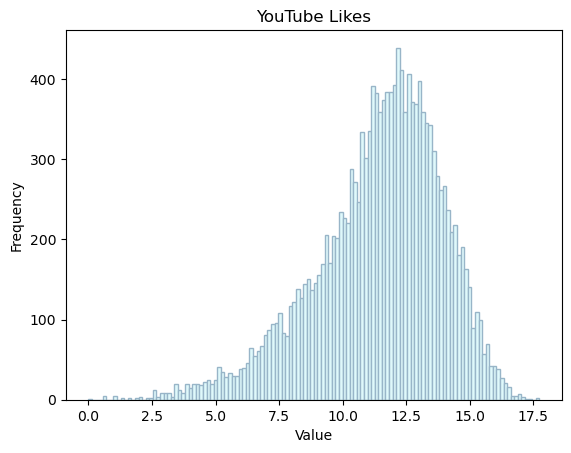

In [12]:
plt.hist(
    np.log1p(X_train["Likes"]),
    bins=int(len(X_train) ** 0.5), 
    edgecolor="#98b5c8", 
    color="#dff9fb"
)
plt.title("YouTube Likes")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

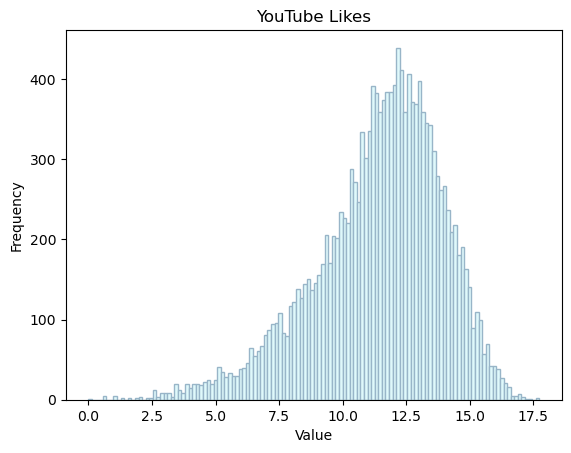

In [14]:
np.log1p(X_train["Likes"]).plot(kind="hist", 
                                bins=int(len(X_train) ** 0.5), 
                                edgecolor="#98b5c8", 
                                color="#dff9fb",
                                title='YouTube Likes')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

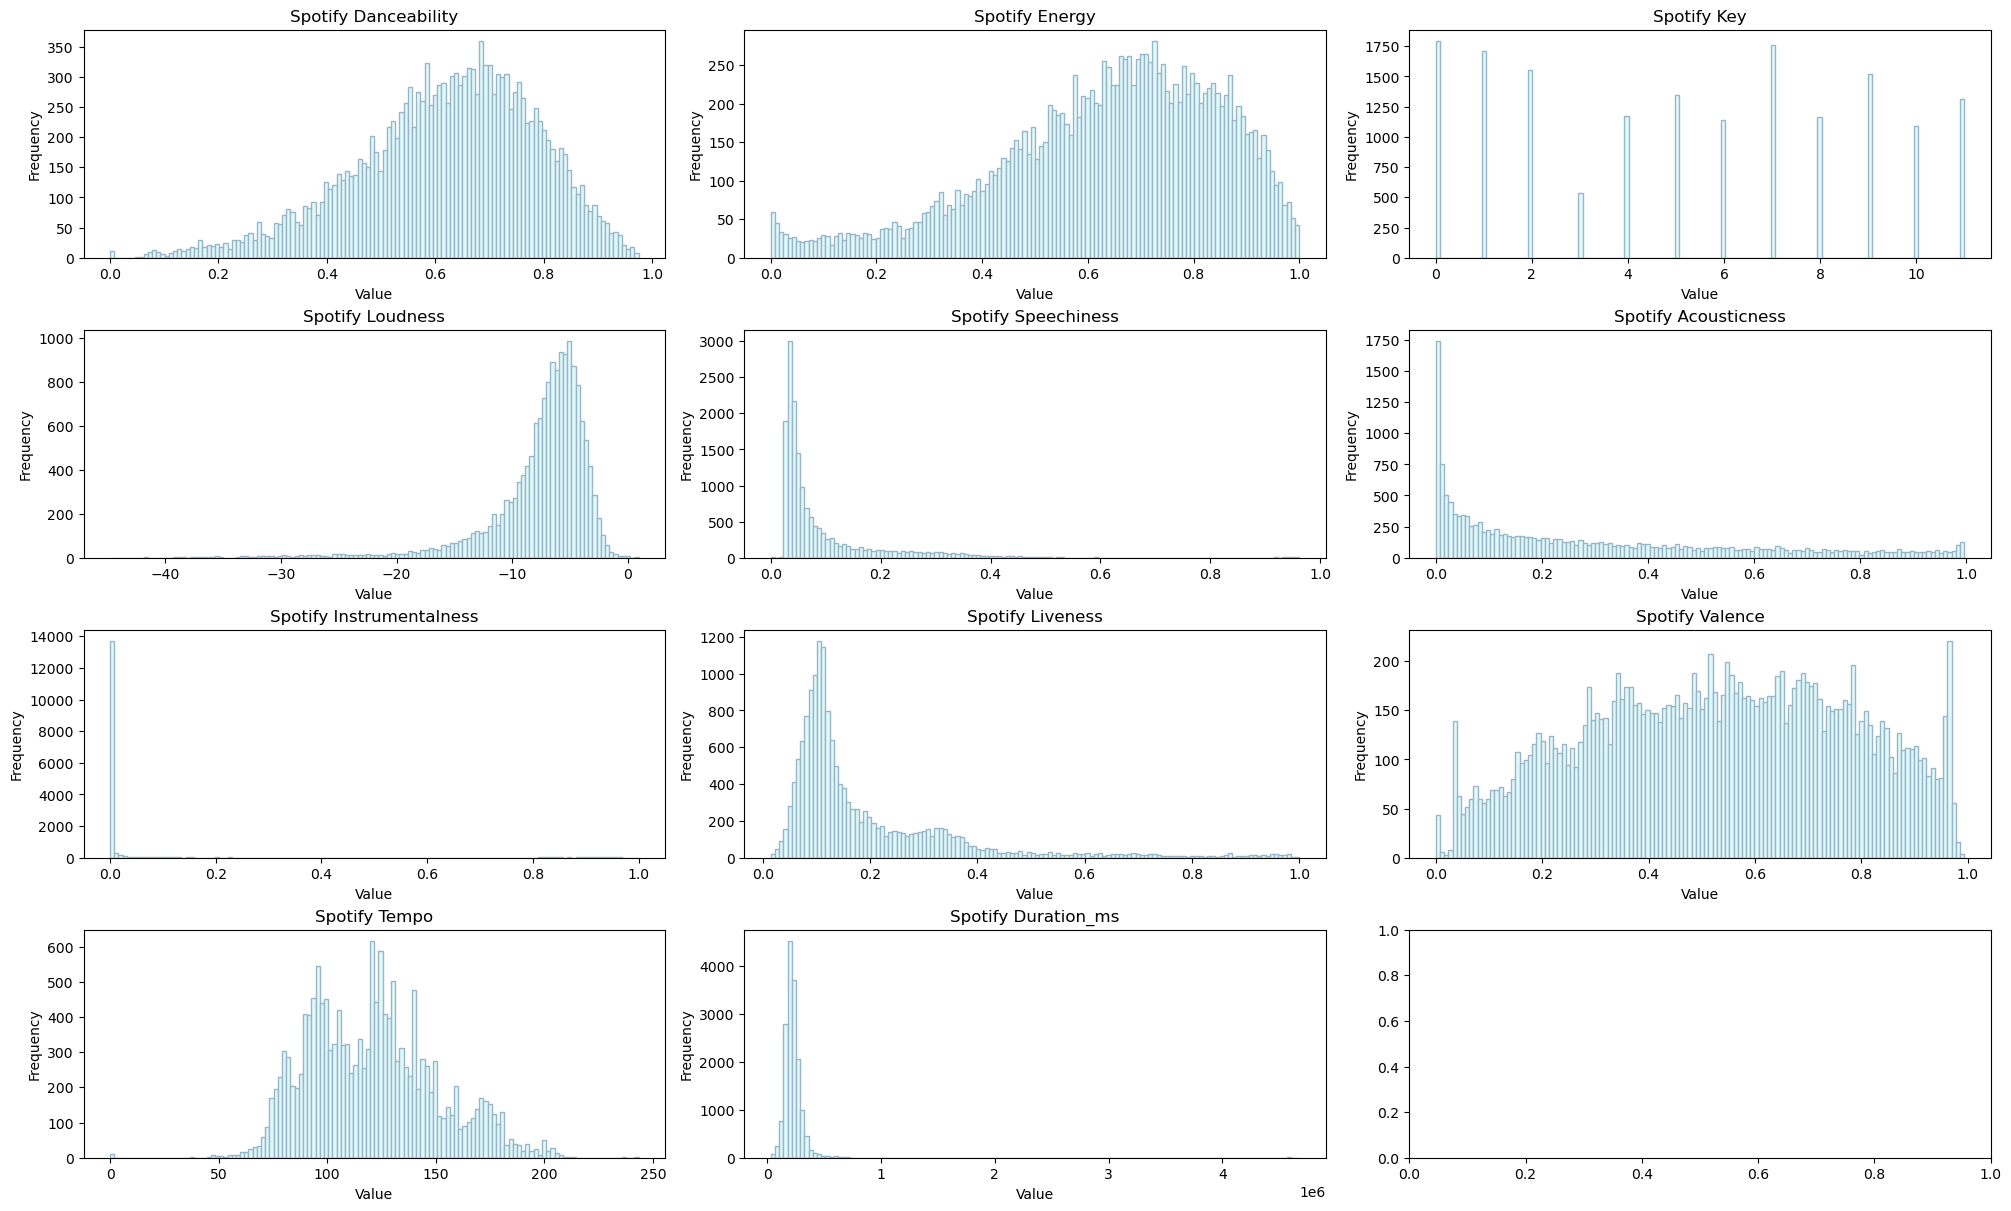

In [16]:
spotify_features = [
    "Danceability", "Energy", "Key", "Loudness", "Speechiness",
    "Acousticness", "Instrumentalness", "Liveness", "Valence",
    "Tempo", "Duration_ms"
]
fig, axes = plt.subplots(4, 3, figsize=(20, 12), constrained_layout=True)
axes = axes.ravel()
for i, f in enumerate(spotify_features):
    axes[i].hist(
        X_train[f],
        bins=int(len(X_train) ** 0.5),
        edgecolor="#98b5c8", 
        color="#dff9fb"
    )
    axes[i].set_title(f"Spotify {f}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel('Frequency')

plt.show()

# Preprocessing

In [770]:
X_train, X_val = preprocess(X_train=X_train, X_val=X_val).values()

# Model
## Ensemble Learning

In [776]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split


# 假設你已有 X_train, y_train, X_val, y_val，如果還沒可以這樣切：
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 原始模型們
models = {
    "XGBRegressor": XGBRegressor(
        n_estimators=600,
        learning_rate=0.1,
        objective="reg:absoluteerror",
        eval_metric=["mae", "rmse"],
        random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.1,
        max_depth=8,
        num_leaves=31,
        min_data_in_leaf=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=600,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=5,
        random_seed=42,
        verbose=False
    )
}

results = {}

# 單獨訓練與評估原始模型
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

# 🧠 加入 Stacking 模型
print("Training Stacking Regressor...")

stacking_model = StackingRegressor(
    estimators=[
        ("xgb", models["XGBRegressor"]),
        ("lgb", models["LightGBM"]),
        ("cat", models["CatBoost"])
    ],
    final_estimator=HistGradientBoostingRegressor(random_state=42),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_stack)
rmse = mean_squared_error(y_val, y_pred_stack, squared=False)
r2 = r2_score(y_val, y_pred_stack)
results["Stacking"] = {"MAE": mae, "RMSE": rmse, "R2": r2}
print(f"Stacking - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

# 結果統整
results_df = pd.DataFrame(results).T
print(results_df)


Training XGBRegressor...
XGBRegressor - MAE: 74058271.84, RMSE: 152380076.28, R²: 0.6346

Training LightGBM...
LightGBM - MAE: 74864746.32, RMSE: 135003396.26, R²: 0.7132

Training CatBoost...
CatBoost - MAE: 75180765.98, RMSE: 140348498.93, R²: 0.6900

Training Stacking Regressor...
Stacking - MAE: 73859099.14, RMSE: 137465531.21, R²: 0.7026

                       MAE          RMSE        R2
XGBRegressor  7.405827e+07  1.523801e+08  0.634591
LightGBM      7.486475e+07  1.350034e+08  0.713178
CatBoost      7.518077e+07  1.403485e+08  0.690016
Stacking      7.385910e+07  1.374655e+08  0.702621


# Explanation
## SHAP 

In [781]:
import shap
import itertools

In [785]:
# calculate Shapley value for each model
tree_shap_results = {}
shap_sample = X_val.iloc[:600]
    
for name in models.keys():
    model = models[name]
    explainer = shap.TreeExplainer(model)

    explanation = explainer(shap_sample)
    feature_importance = np.abs(explanation.values).mean(axis=0)

    # select top 20 features
    top_features_idx = np.argsort(feature_importance)[-20:][::-1]
    top_features = [explanation.feature_names[i] for i in top_features_idx]

    tree_shap_results[name] = {
        "explainer": explainer,
        "explanation": explanation,
        "top_features_idx": top_features_idx,
        "top_features": top_features
    }
    print(f"{name} - Important features: {top_features[:10]}")

XGBRegressor - Important features: ['Likes', 'Views', 'Title_keyword_official', 'Artist_avg_likes', 'Likes_per_Comment', 'Album_type_album', 'Comments', 'Artist_mood_style', 'Title_length', 'Artist_energy_style']
LightGBM - Important features: ['Likes', 'Views', 'Title_keyword_official', 'Likes_per_Comment', 'Artist_avg_likes', 'Album_type_album', 'Artist_mood_style', 'Artist_energy_style', 'Artist_dance_style', 'official_video']
CatBoost - Important features: ['Likes', 'Views', 'Title_keyword_official', 'Comments', 'Likes_per_Comment', 'Artist_avg_likes', 'Album_type_album', 'Artist_avg_views', 'Artist_mood_style', 'Duration_ms']


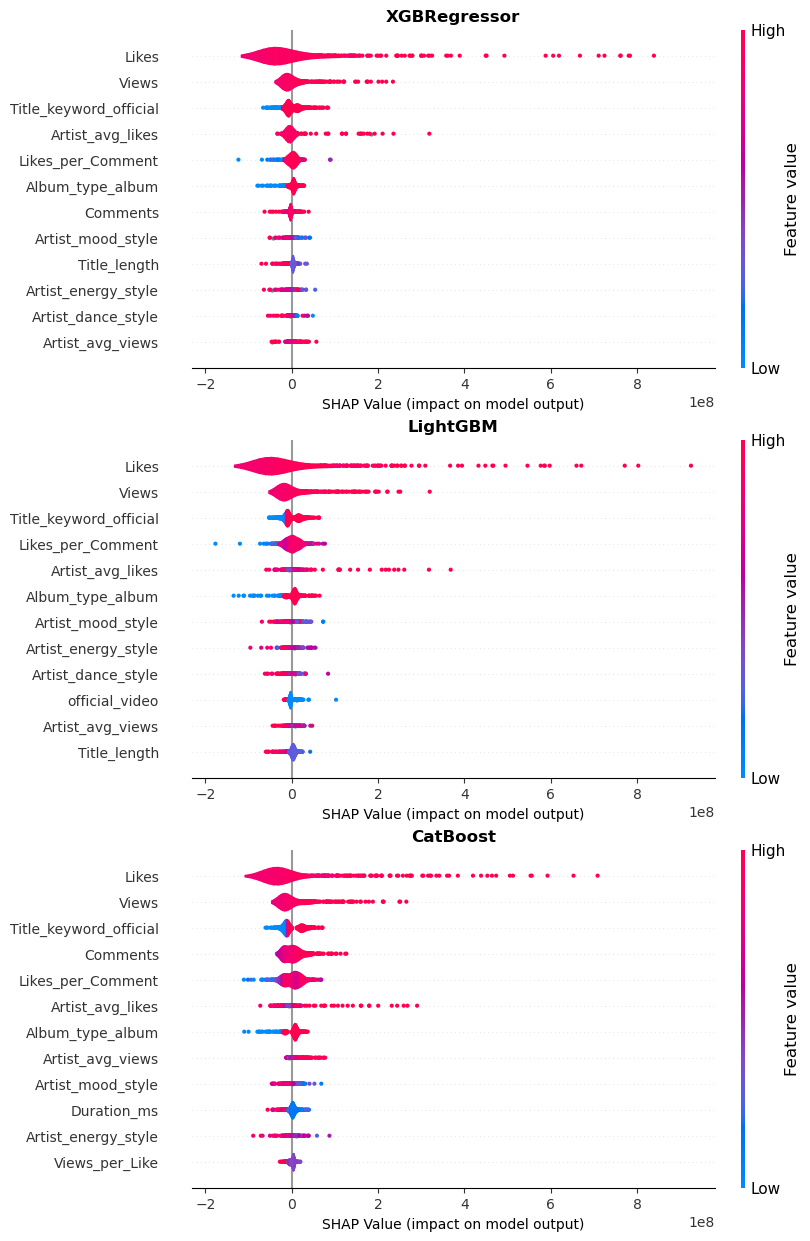

In [786]:
TEXTSIZE = 10

fig, axes = plt.subplots(
    len(tree_shap_results), 1,
    sharex="all",
    constrained_layout=True
)
axes = axes.ravel()

for i, name in enumerate(tree_shap_results.keys()):
    explanation = tree_shap_results[name]["explanation"]
    ax = axes[i]
    plt.sca(ax)

    shap.plots.violin(
        explanation,
        max_display=12,
        plot_size=0.9,
        show=False
    )

    ax.set_xlabel("SHAP Value (impact on model output)", fontsize=TEXTSIZE)    
    ax.set_title(name, weight="bold")
    ax.tick_params(labelsize=TEXTSIZE)

plt.show()


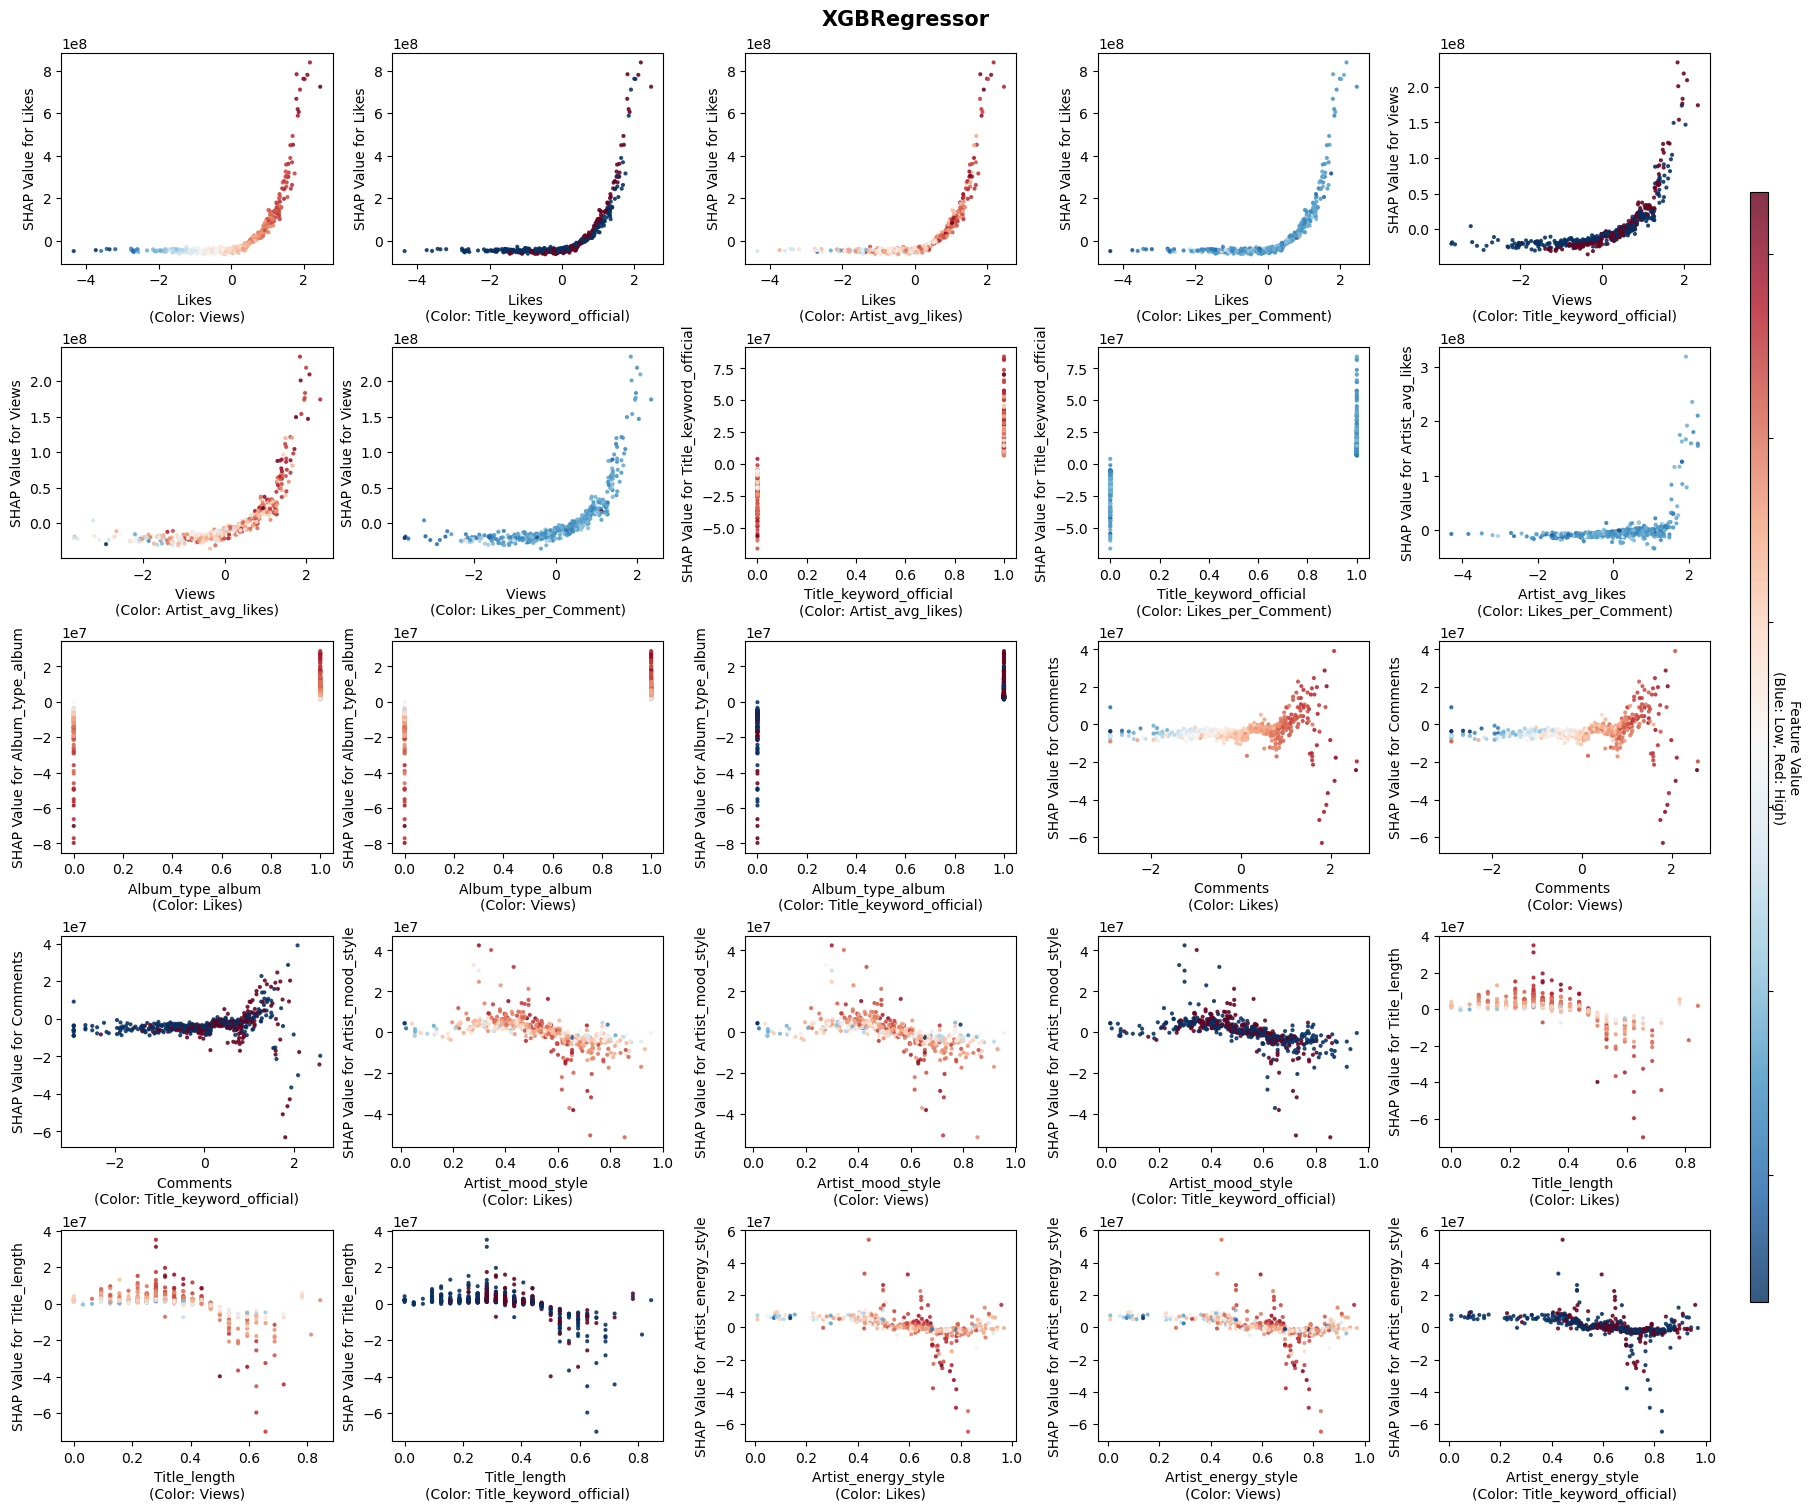

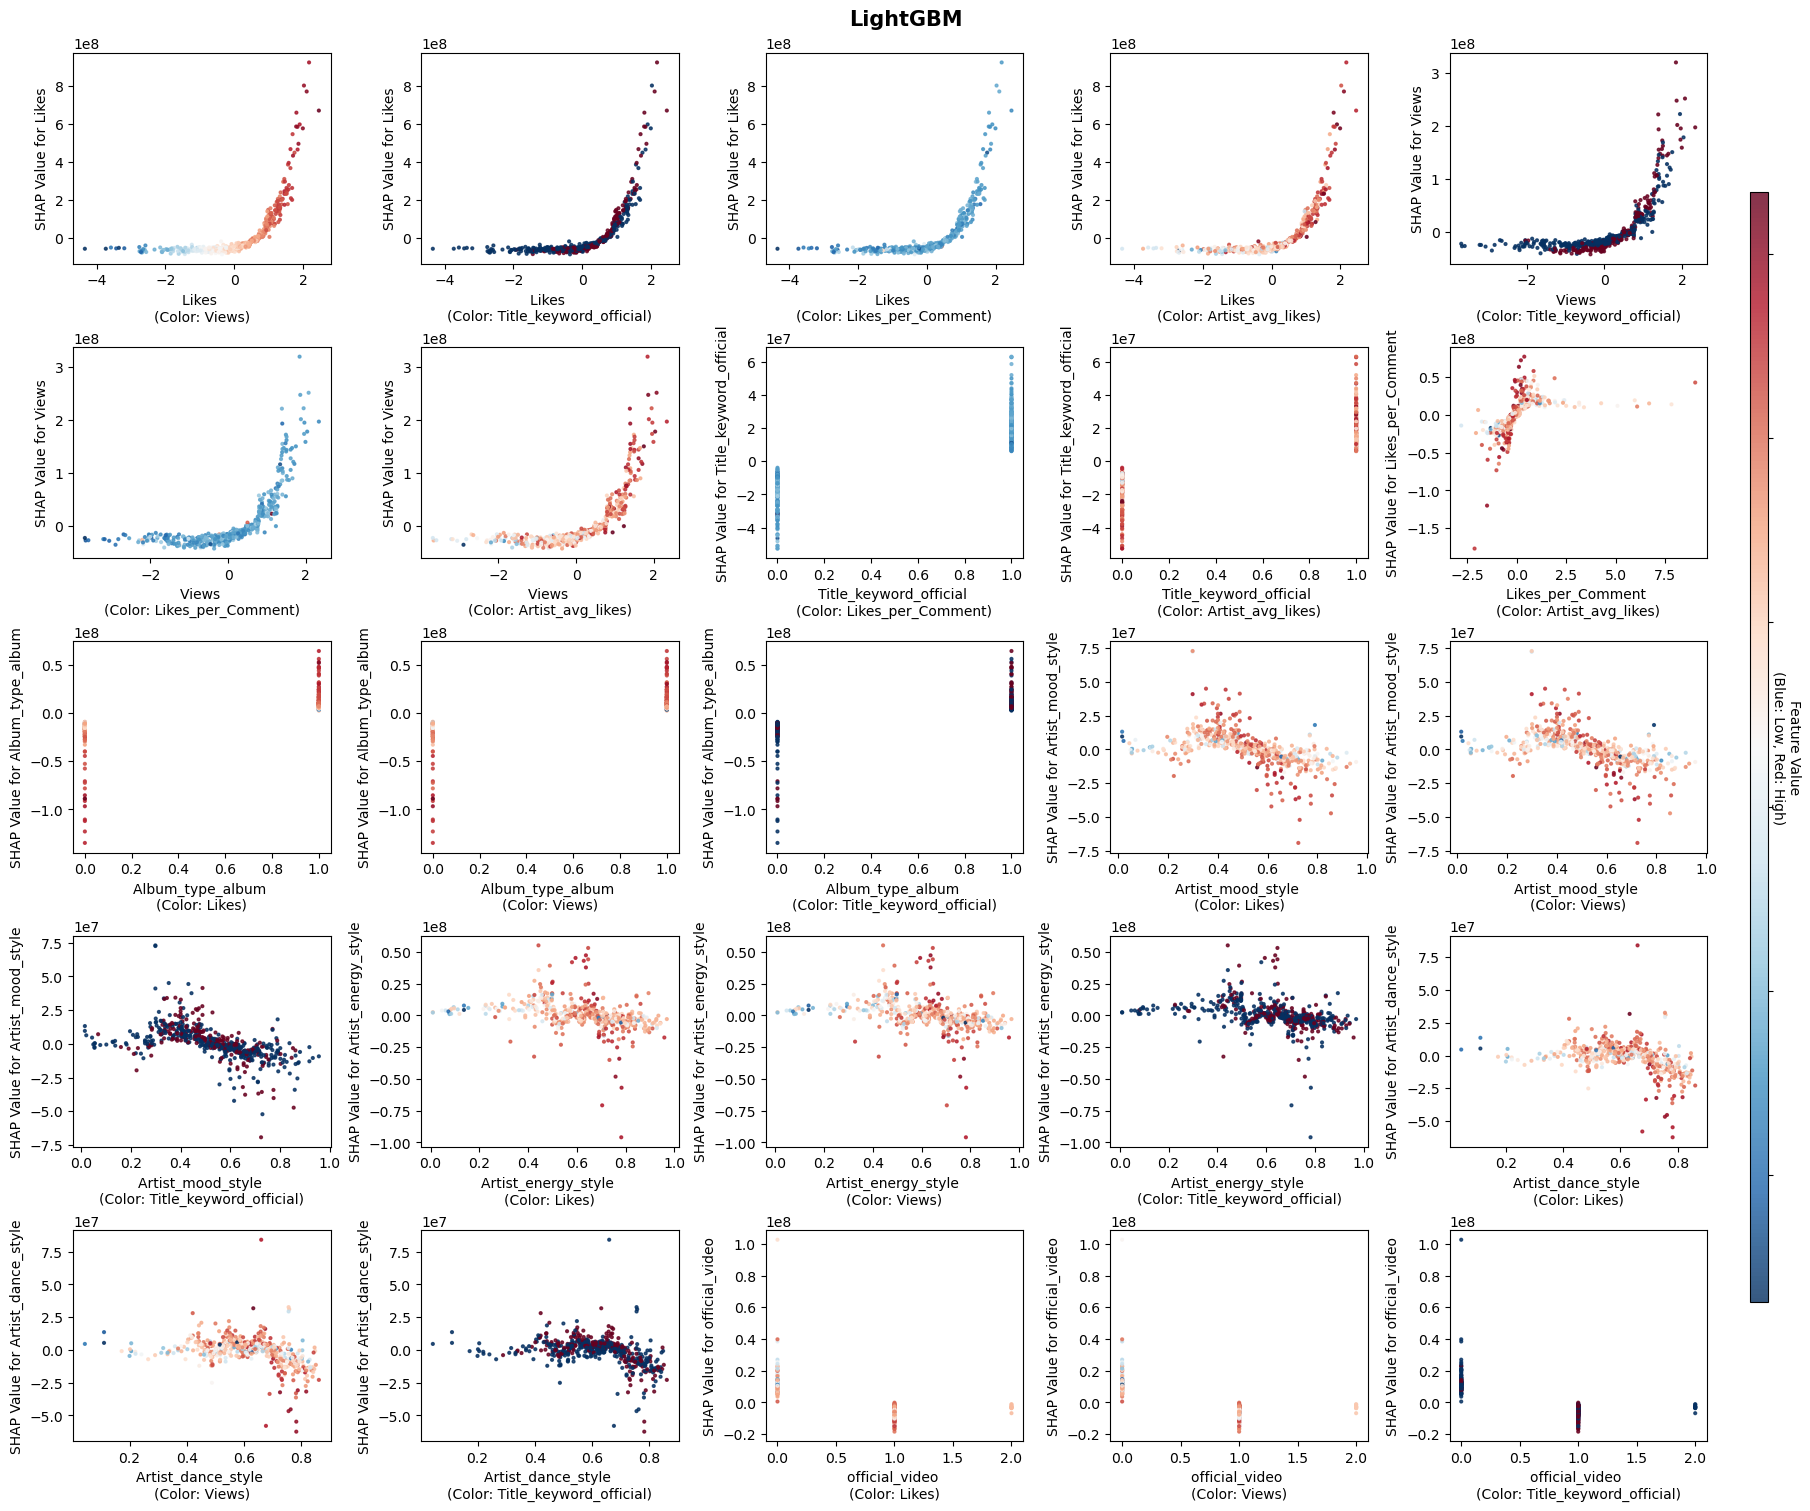

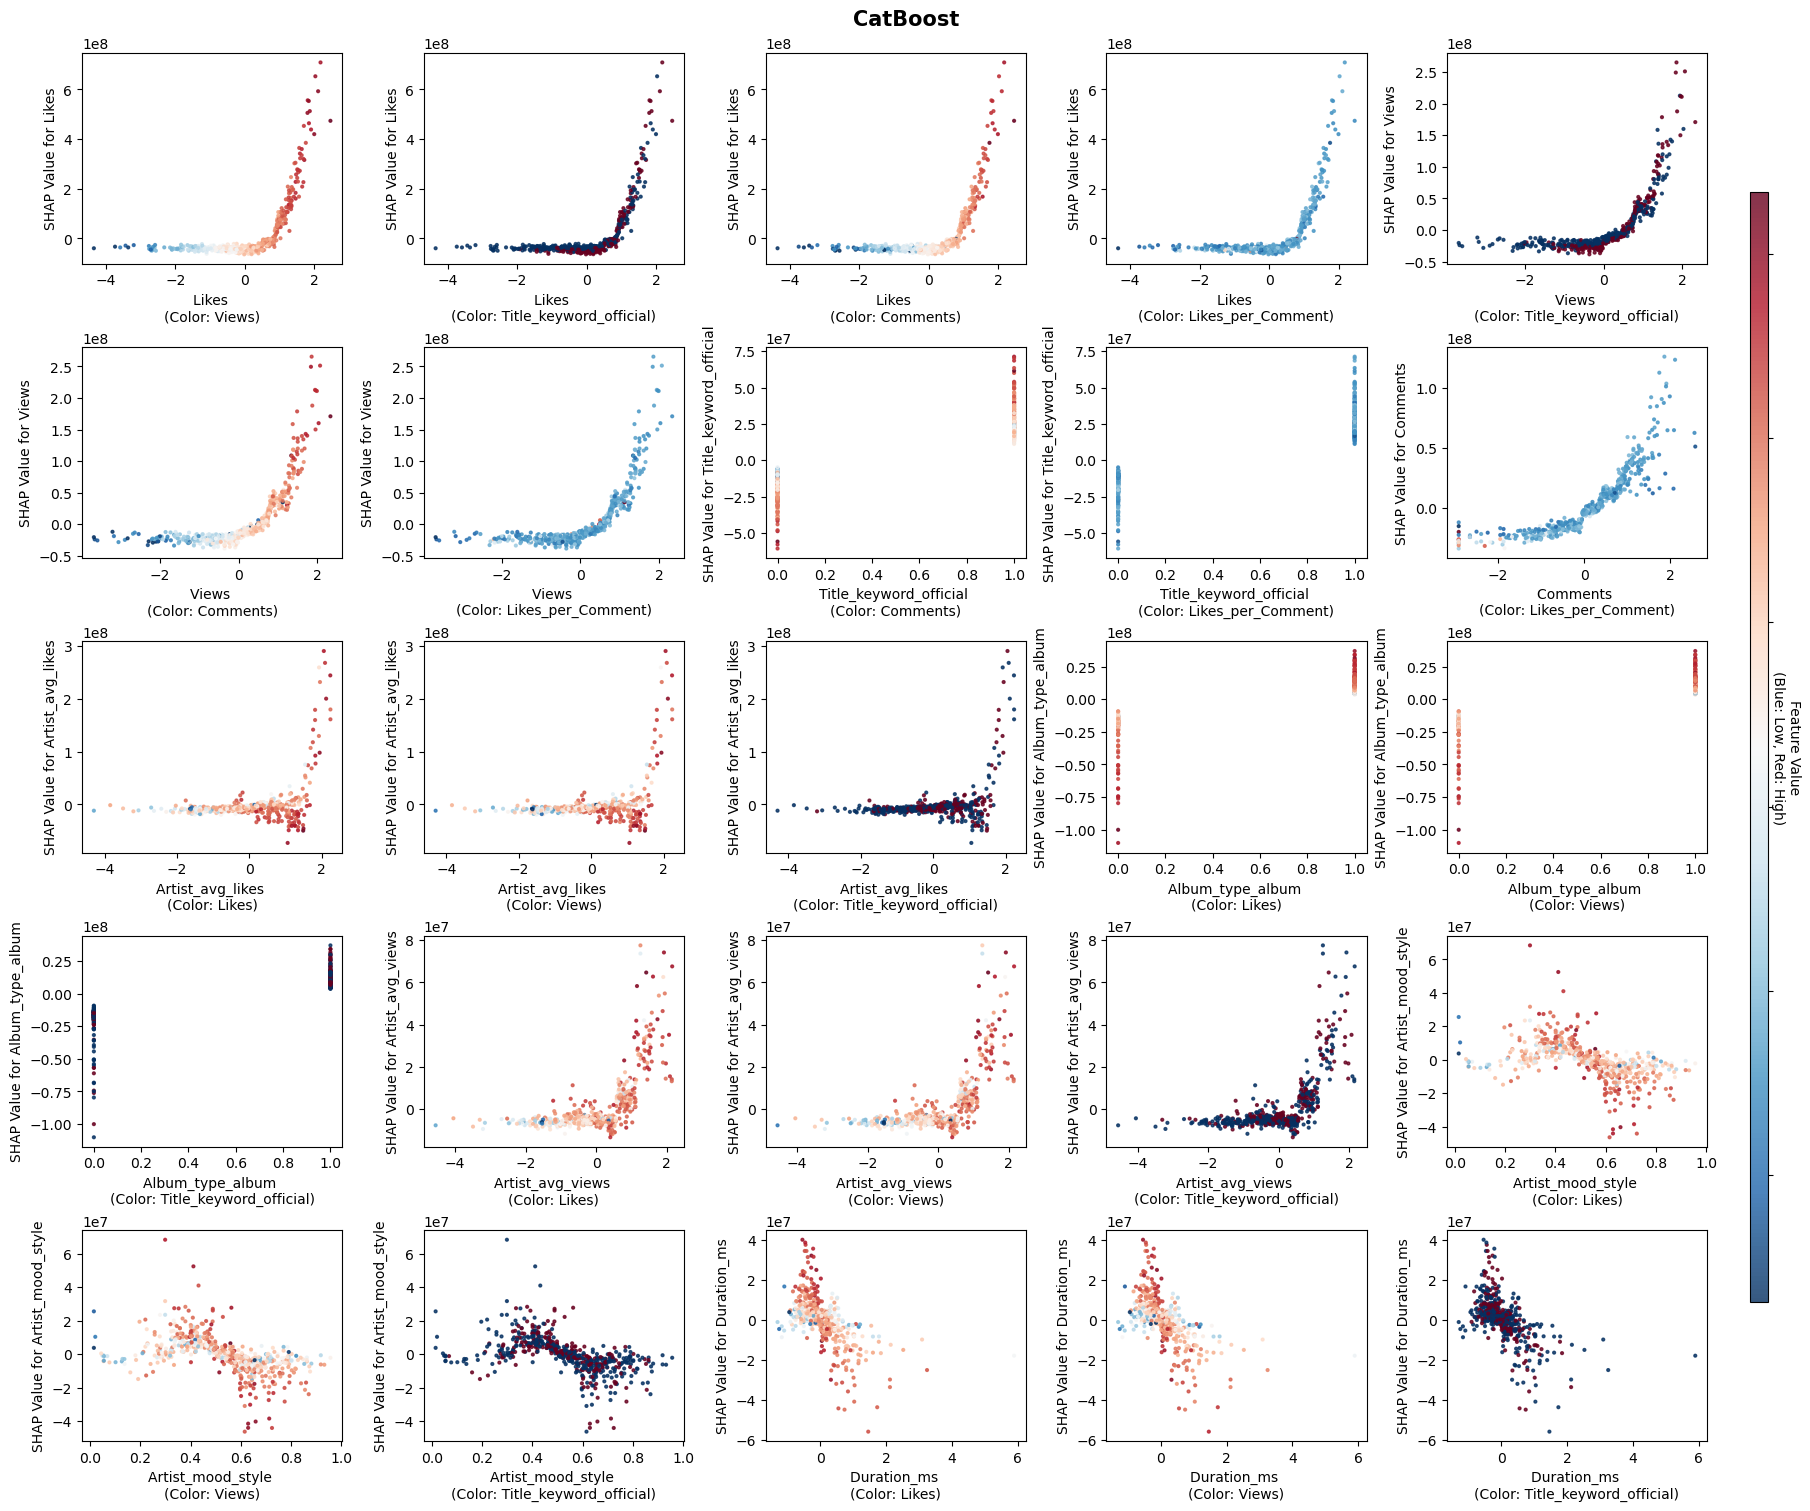

In [787]:
# 交互關係
for i, name in enumerate(tree_shap_results.keys()):
    explanation = tree_shap_results[name]["explanation"]
    
    # select top10 features for plot
    top_features_idx = tree_shap_results[name]["top_features_idx"][:10]
    
    # total 25 pairs 
    features_interation = list(itertools.combinations(top_features_idx[:5], 2)) + \
        list(itertools.product(top_features_idx[5:], top_features_idx[:3]))
    
    row_cnt = int(np.sqrt(len(features_interation)))
    col_cnt = int(len(features_interation) / row_cnt)
    fig, axes = plt.subplots(
        row_cnt, col_cnt,
        figsize=(18, 15),
        constrained_layout=True
    )
    axes = axes.ravel()
    fig.suptitle(name, weight="bold", fontsize=TEXTSIZE * 1.5)

    scatter_plots = []
    for j, pair in enumerate(features_interation):
        feature1, feature2 = explanation.feature_names[pair[0]], explanation.feature_names[pair[1]]
        
        scatter_plots.append(
            axes[j].scatter(
            shap_sample[feature1], 
            explanation.values[:, pair[0]],
            c=shap_sample[feature2], 
            cmap="RdBu_r", 
            alpha=0.8,
            s=4
        ))
        axes[j].set_xlabel(f"{feature1} \n(Color: {feature2})", fontsize=TEXTSIZE)
        axes[j].set_ylabel(f"SHAP Value for {feature1}", fontsize=TEXTSIZE)

    cbar = fig.colorbar(scatter_plots[0], ax=axes, shrink=0.8, aspect=60, pad=0.02)
    cbar.set_label("Feature Value\n(Blue: Low, Red: High)", fontsize=TEXTSIZE, rotation=270, labelpad=20)
    cbar.ax.tick_params(
        labelright=False,
        labelsize=TEXTSIZE * 0.8
    )
    plt.show()


## Counterfactual Explanation

In [814]:
import re
from scipy.optimize import minimize

np.random.seed(42)

# 可調整的特徵類型
MUTABLE_PATTERNS = {
    "partial_match": [
        r"_keyword_", r"_sentiment_(neg|neu|pos|compound)$", r"_length$", r"^Album_type_"
    ],
    "exact_match": [
        "Energy", "Key", "Danceability", "Valence", "Tempo", "Loudness",
        "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Duration_ms"
    ]
}

def is_mutable(feature_name):
    return (
        feature_name in MUTABLE_PATTERNS["exact_match"] or
        any(re.search(p, feature_name) for p in MUTABLE_PATTERNS["partial_match"])
    )

def get_bounds(feature_name):
    std_features = ["Key" , "Loudness", "Tempo", "Duration_ms"]  # 常態標準化的變數
    if feature_name in std_features:
        return (-3, 3)
    else:
        return (0, 1)

def generate_counterfactual(
        instance, 
        model, 
        threshold, 
        mutable_mask=None, 
        lambda_sparsity=0.1, 
        signif_change=1e-3,
        trials=3):
    
    original_pred = model.predict(instance.to_numpy().reshape(1, -1))[0]
    x0 = instance.copy()
    
    if mutable_mask is None:
        mutable_mask = np.array([is_mutable(name) for name in instance.index], dtype=int)
    
    def objective(x):
        changes = np.abs(x - x0)
        l1_distance = np.sum(changes * mutable_mask)
        
        # penalty term
        num_changes = np.sum((changes > signif_change) * mutable_mask)
        sparsity_penalty = lambda_sparsity * num_changes
        
        return l1_distance + sparsity_penalty

    def constraint(x):
        return model.predict(x.reshape(1, -1))[0] - threshold

    bounds = []
    for i, (name, value) in enumerate(zip(instance.index, x0)):
        if mutable_mask[i]:
            bounds.append(get_bounds(name))
        else:
            bounds.append((value, value))

    # optimization: min ||x' - x||_p s.t. f(x') ≥ threshold
    best_result = None
    best_distance = float("inf")
    
    # try different initialization
    for attempt in range(trials):
        if attempt == 0:
            init_x = x0.copy()
        elif attempt == 1:
            init_x = x0.copy()
            for i in range(len(init_x)):
                if mutable_mask[i]:
                    lower, upper = bounds[i]
                    noise = np.random.uniform(-0.1, 0.1) * (upper - lower)
                    init_x[i] = np.clip(init_x[i] + noise, lower, upper)
        else:
            init_x = x0.copy()
            for i in range(len(init_x)):
                if mutable_mask[i]:
                    lower, upper = bounds[i]
                    init_x[i] = np.random.uniform(lower, upper)

        result = minimize(
            objective,
            x0=init_x,
            bounds=bounds,
            constraints={"type": "ineq", "fun": constraint},
            method="SLSQP",
            options={"maxiter": 5000, "ftol": 1e-8}
        )
        
        if result.success:
            distance = objective(result.x)
            if distance < best_distance:
                best_distance = distance
                best_result = result

    if best_result and best_result.success:
        return {
            "cf": best_result.x,
            "num_changes": np.sum((np.abs(best_result.x - x0) > signif_change) * mutable_mask),
            "cf_pred": model.predict(best_result.x.reshape(1, -1))[0],
            "original_pred": original_pred
        }
    else:
        return {
            "cf": None,
            "num_changes": None,
            "cf_pred": None,
            "original_pred": original_pred
        }

In [829]:
best_model_name = "LightGBM"
top_features = tree_shap_results[best_model_name]["top_features"]

# Target: Stream > pr70 
threshold = np.percentile(y_train, 70)

# 隨機抓 20 data with original_pred < threshold 做 Counterfactual
test_idx = []
shuffle = X_train.sample(frac=1, random_state=0)
for idx in shuffle.index:
    original_pred = models[best_model_name].predict(shuffle.loc[idx].to_numpy().reshape(1, -1))
    if original_pred < threshold:
        test_idx.append(idx)
        if len(test_idx) == 20:
            break

# focus on top features (20)
mutable_mask = np.array([name in top_features and is_mutable(name) for name in X_train.columns], dtype=int)
signif_change = 1e-3
successful_cf = 0
for idx in test_idx:
    instance = shuffle.loc[idx]
    cf_result = generate_counterfactual(
        instance,
        models[best_model_name],
        threshold,
        mutable_mask=mutable_mask,
        signif_change=signif_change
    )

    # counterfactual result
    cf, num_changes, cf_pred, original_pred = cf_result.values()
    if cf is not None:
        successful_cf += 1
        instance_uri = data.loc[idx, "Uri"]

        print(
            f"{successful_cf}. Sample {instance_uri}:",
            f"Predict value from {original_pred: .0f} to {cf_pred: .0f} (significant change: {num_changes} variables.)",
            sep="\n"
        )
        for name, orig, new in zip(instance.index, instance, cf_result["cf"]):
            if np.abs(new - orig) >= signif_change:
                print(f"\t{name}: {orig: .3f} -> {new: .3f} (Δ = {new - orig: .3f})")

        print()

print(f"Success rate: {successful_cf / len(test_idx)}")

1. Sample spotify:track:74AqVxZ3oXwJ8olHssBUG3:
Predict value from  71842664 to  122313905 (significant change: 1 variables.)
	Speechiness:  0.028 ->  0.034 (Δ =  0.006)

2. Sample spotify:track:2vwlzO0Qp8kfEtzTsCXfyE:
Predict value from  108459720 to  130291455 (significant change: 0 variables.)

3. Sample spotify:track:1qy7aOHnfnOMJoT1fhoLYG:
Predict value from  11789084 to  114820625 (significant change: 5 variables.)
	Acousticness:  0.074 ->  0.097 (Δ =  0.024)
	Valence:  0.698 ->  0.871 (Δ =  0.173)
	Duration_ms: -0.121 ->  0.048 (Δ =  0.168)
	Title_length:  0.250 ->  0.302 (Δ =  0.052)
	Description_length:  0.047 ->  0.005 (Δ = -0.043)

4. Sample spotify:track:13cpOnmccZGVGFngLxYN4I:
Predict value from  9090546 to  110567215 (significant change: 6 variables.)
	Speechiness:  0.195 ->  0.004 (Δ = -0.191)
	Acousticness:  0.105 ->  0.996 (Δ =  0.891)
	Valence:  0.636 ->  0.004 (Δ = -0.632)
	Duration_ms: -0.907 -> -0.523 (Δ =  0.384)
	Title_length:  0.219 ->  0.996 (Δ =  0.777)
	Descr

# Prototype Explainer

In [84]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

# 音訊特徵欄位
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
                  'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']

X_train = X_train.dropna(subset=audio_features)
X_val = X_val.dropna(subset=audio_features)

# --- Step 1: 選出播放次數最高前 10% 的歌曲 ---
threshold = y_train.quantile(0.9)
top_songs = X_train[y_train >= threshold]

# 計算熱門歌曲的平均特徵向量（prototype）
prototype_vector = top_songs[audio_features].mean()

# --- Step 2: 計算 validation set 中每首歌與 prototype 的歐式距離 ---
val_features = X_val[audio_features]
distances = euclidean_distances(val_features, [prototype_vector])
X_val = X_val.copy()  # 避免 SettingWithCopyWarning
X_val['distance_to_prototype'] = distances

# --- Step 3: 找出距離最遠的前 5 首歌 ---
top_n = 5
farthest_songs = X_val.sort_values('distance_to_prototype', ascending=False).head(top_n)

# --- Step 4: 對每一首距離最遠的歌給出優化建議 ---
for idx, row in farthest_songs.iterrows():
    print("🎵 距離熱門歌曲 prototype 最遠的第", idx+1, "首歌是：", row['Track'], "by", row['Artist'])
    print("📏 距離：", row['distance_to_prototype'])
    print("\n📊 優化建議：")
    
    for feature in audio_features:
        song_value = row[feature]
        proto_value = prototype_vector[feature]
        delta = proto_value - song_value
        
        if abs(delta) > 0.05:
            direction = "提升" if delta > 0 else "降低"
            print(f"- 將 `{feature}` {direction} 至熱門歌曲平均值 {proto_value:.2f}（目前為 {song_value:.2f}）")
    
    print("-" * 50)


🎵 距離熱門歌曲 prototype 最遠的第 15589 首歌是： Clean White Noise - Loopable with no fade by White Noise Baby Sleep
📏 距離： 123.03268418702443

📊 優化建議：
- 將 `Danceability` 提升 至熱門歌曲平均值 0.65（目前為 0.00）
- 將 `Energy` 提升 至熱門歌曲平均值 0.67（目前為 0.00）
- 將 `Key` 降低 至熱門歌曲平均值 5.31（目前為 8.00）
- 將 `Loudness` 提升 至熱門歌曲平均值 -6.33（目前為 -28.46）
- 將 `Speechiness` 提升 至熱門歌曲平均值 0.09（目前為 0.00）
- 將 `Acousticness` 降低 至熱門歌曲平均值 0.20（目前為 0.79）
- 將 `Instrumentalness` 降低 至熱門歌曲平均值 0.01（目前為 1.00）
- 將 `Liveness` 提升 至熱門歌曲平均值 0.18（目前為 0.11）
- 將 `Valence` 提升 至熱門歌曲平均值 0.53（目前為 0.00）
- 將 `Tempo` 提升 至熱門歌曲平均值 120.99（目前為 0.00）
--------------------------------------------------
🎵 距離熱門歌曲 prototype 最遠的第 13846 首歌是： Soothing White Noise - Loopable, No Fade by White Noise for Babies
📏 距離： 122.92635301989553

📊 優化建議：
- 將 `Danceability` 提升 至熱門歌曲平均值 0.65（目前為 0.00）
- 將 `Energy` 提升 至熱門歌曲平均值 0.67（目前為 0.00）
- 將 `Key` 提升 至熱門歌曲平均值 5.31（目前為 1.00）
- 將 `Loudness` 提升 至熱門歌曲平均值 -6.33（目前為 -27.59）
- 將 `Speechiness` 提升 至熱門歌曲平均值 0.09（目前為 0.00）
- 將 `Acousticness` 降低 至熱門歌曲平均值

/var/folders/78/5p9022tn11505m8nkdj4dfph0000gn/T/ipykernel_71710/2310471370.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_songs = X_train[y_train >= threshold]
